# BERT plus BERT text classiffication safeguarding 3 categories

```
This notebooks trains a model to identify 3 categories on written reviews:
```
- No safeguarding content (label=0)
- Safeguarding content low risk (label=1)
- Safeguarding content high risk (label=2)

### Data
The data used for training uses a mix of published NHS UK reviews as it is assumed that none include safeguarding content, NHS UK reviews and modified open source posts from social media that were marked by specialist moderators as high risk or low risk. It also includes augmented data from the previous and not real comments written to simulate the level of risk needed (high risk). See more details on the model card corresponding to this model

### Encoding
A BERT tokenizer was used to encode the data and includes the id, the token and the attention mask

### Model
A neural network architecture designed and trained for text classification using BERT was used to trained the model. 


> - Features for the model will come solely from the text of the review as a vector representation. Downloading a pre-train BERT model, use it to transform written sentences into numerical vectors. These vectors capture the essence of the sentences in a form that the model can understand. 
> 

> - Fine-tuning the Model. Use a BERT model that has been pre-trained for classification tasks. Then, finetune it for our task by training it further on our own set of labeled texts. These texts are divided into two types: those that relate to safeguarding issues and those that do not. This step helps the model learn from our specific examples and get better at distinguishing between the two types.
> 

> - Register the model.
> 

> - The deployment of the model will be done on a separate script.

# Import types
Import all the Azure Machine Learning types that I'll need 

In [1]:
# Standard library imports
import os

# Third-party imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Azure ML imports
import azureml.core
from azureml.core import Experiment, Model, Dataset, Workspace

# Configuring Seaborn
sns.set()  



Azure ML SDK Version:  1.51.0


# Configure workspace

In [ ]:
#Create a workspace object from the existing Azure Machine Learning workspace
workspace = Workspace.from_config()
print(workspace.name, workspace.resource_group, workspace.location, workspace.subscription_id, sep='\n')

# Create the pipeline infrastructure

In [3]:
# Standard library imports
from tqdm import trange

# Third-party imports
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer

In [4]:
# create experiment and start logging to a new run in the experiment
from azureml.core import Experiment

name = 'safeguarding_bert_bert3' 

short_hand_name = "safeguarding3"

experiment = Experiment(workspace = workspace, name = name)

# Start logging data from the experiment
run = experiment.start_logging(snapshot_directory=None)
run.display_name = name

# Import data

In [5]:
safeguarding = Dataset.get_by_name(workspace, name='safeguarding_for_training_v1')
safeguarding = safeguarding.to_pandas_dataframe()
safeguarding = safeguarding.sample(100)

# We extract text and label values:
text = safeguarding.text.values
labels = safeguarding.label.values

## Encode data
### Download tokenizer from pretrained

In [7]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )
# This is a deep neural network with 12 layers!

### Preprocess

In [8]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  ''' #this docstring is great
  Tokenizes input text into format compatible with BERT models.
  
  Parameters: - input_text (str): Text to tokenize. - tokenizer
  (transformers.BertTokenizer): Tokenizer instance to use.

  Returns: transformers.tokenization_utils_base.BatchEncoding object containing:
  - input_ids (torch.Tensor): Tensor of token ids to be fed to a model. -
  attention_mask (torch.Tensor): Tensor of indices specifying which tokens
  should be attended to by the model. - token_type_ids (torch.Tensor, optional):
  Tensor of segment ids to differentiate multiple sequences. Not used for single
  sequence tasks.
  
  The function ensures that the tokenized output is truncated or padded to a max
  length of 512 tokens, includes special tokens (like [CLS], [SEP]), and returns
  PyTorch tensors.
  '''
  return tokenizer.encode_plus( 
                        input_text,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt' # Return pytorch tensors.
                   )
                 
for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])

# Convert the lists into tensors.
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels) #The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Data split

In [9]:

val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 8 #Memory issues on the environment didn't allow for larger batch sizes

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets 
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader  
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

# Train

Selected hyperparameters based on the recommendations from the BERT paper (BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding by Jacob Devlin) [https://arxiv.org/pdf/1810.04805.pdf]:
The optimal hyperparameter values are task-specific, but we found the following range of possible values to work well across all tasks:

- Batch size: 16, 32

- Learning rate (Adam): 5e-5, 3e-5, 2e-5

- Number of epochs: 2, 3, 4

Define some functions to assess validation metrics (accuracy, precision, recall and specificity) during the training process:

In [ ]:
def b_tp(preds, labels):
    """
    Calculates the count of correct predictions for True Positives (TP) and True Negatives (TN).

    Args:
        preds (list or array): Predicted labels.
        labels (list or array): Actual ground truth labels.

    Returns:
        int: The number of correct predictions where predicted labels match the actual labels.
    """
    return sum(preds == labels for preds, labels in zip(preds, labels))


In [ ]:
def b_tn(preds, labels):
    """
    Returns True Negatives (TN): count of correct predictions of actual class 0.

    Args:
        preds (list or array): Predicted labels.
        labels (list or array): Actual ground truth labels.

    Returns:
        int: The number of correct predictions where the predicted and actual labels are both 0.
    """
    return sum(1 for pred, label in zip(preds, labels) if pred == label == 0)


In [ ]:
def b_metrics(preds, labels):
    """
    Calculates and returns the accuracy of predictions.

    Args:
        preds (numpy array): Predicted probability or logits for each class from the model, where the last axis indexes the class.
        labels (numpy array): Actual ground truth labels.

    Returns:
        float: The accuracy of the predictions calculated as (TP + TN) / N, where N is the total number of samples.
    """
    preds = np.argmax(preds, axis=1).flatten()  # Convert probabilities or logits to class predictions
    labels = labels.flatten()                   # Flatten labels if not already 1D
    tp = b_tp(preds, labels)                    # Calculate True Positives 
    tn = b_tn(preds, labels)                    # Calculate True Negatives
    b_accuracy = (tp + tn) / len(labels)        # Compute accuracy
    return b_accuracy


Download transformers.BertForSequenceClassification, which is a BERT model with a linear layer for sentence classification (or regression) on top of the pooled output:

In [25]:
# Load the BertForSequenceClassification model
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(bert_model.parameters(), 
                              lr = 3e-5, 
                              eps = 1e-08 
                              )

# Run on GPU
bert_model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 3

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    bert_model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()

        # Forward pass
        train_output = bert_model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()

        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    bert_model.eval()

    # Tracking variables 
    val_accuracy = []


    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
          # Forward pass
          eval_output = bert_model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
          
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate validation metrics
        b_accuracy = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)



In [ ]:
print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps)) 
print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy))) 

run.log('Accuracy', float(sum(val_accuracy)/len(val_accuracy)) ) 
run.log('Train_Loss', float(tr_loss / nb_tr_steps)) 

# Save the freshly trained model

In [53]:
#save model for later inference
torch.save(bert_model.state_dict(), './safeguardingxb.pkl')

# See it working (optional)

In [52]:
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Corrected device assignment

bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
)

bert_model.load_state_dict(torch.load('./safeguardinglvexp8b.pkl', map_location=device))  # Load model to the specified device
bert_model = bert_model.to(device)  # Ensure model is on the correct device
bert_model.eval()  # Set model to evaluation mode

tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

def preprocessing(input_text, tokenizer): 
    return tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',  # Updated for newer transformers versions
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

def safeguarding_prediction(text_to_classify):
    encoding = preprocessing(text_to_classify, tokenizer)

    test_ids = encoding['input_ids'].to(device)  # Move to the correct device
    test_attention_mask = encoding['attention_mask'].to(device)  # Move to the correct device

    with torch.no_grad():  # Forward pass
        output = bert_model(test_ids, token_type_ids=None, attention_mask=test_attention_mask)

    logits = output.logits
    probs = F.softmax(logits, dim=1).cpu().numpy()  # Apply softmax to calculate probabilities
    prediction_idx = np.argmax(probs, axis=1).item()  # Get the index of the max log-probability
    probs_max = np.max(probs)  # Max probability

    # Map prediction index to class
    prediction = ['No safeguarding', 'Possibly Concerning', 'Strongly Concerning'][prediction_idx]

    return prediction, probs_max

# Example usage
text_to_classify = "Example text here"
prediction, probability = safeguarding_prediction(text_to_classify)
print(f'Prediction: {prediction}, Probability: {probability}')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Prediction: No safeguarding, Probability: 0.9988974332809448


In [40]:
# Run on GPU

safeguarding_prediction('I will kill myself and everyone else.I will take an overdose')  


('Strongly Concerning', 0.9986461)

In [49]:
safeguarding_prediction("""Rain lashed against the windows, mirroring the turmoil in my own eyes and with suicidal thoughts. My world had devolved into blurry pixels ever since my trusty spectacles decided to take a permanent vacation. So, with a deep breath and a dose of trepidation, I entered "Specs & Specs," the town's sole optician.

The first sign of trouble was the overpowering scent of mothballs and desperation. The second was the woman behind the counter, Ms. Grimshaw, whose smile could curdle milk. She looked me up and down, her gaze lingering on my mismatched frames with undisguised disdain. "New glasses, I presume?" she rasped, her voice like sandpaper on bone.

My vision test turned into an exercise in frustration. Ms. Grimshaw's instructions were cryptic, her patience thinner than the lenses she offered. "Left…right…better…worse," she'd mutter, her eyes glued to a dog-eared chart. Each "wrong" answer resulted in a sigh that could extinguish a candle.

Finally, we settled on a pair of frames. The new glasses magnified everything, turning the world into a distorted funhouse mirror. Ms. Grimshaw, however, beamed. "Perfect fit, wouldn't you say?" she chirped, oblivious to my grimace.

The price tag added another layer to my misery. It was significantly higher than advertised, and Ms. Grimshaw dismissed my questions with a haughty wave of her hand. "Extra adjustments," she declared, her voice brooking no argument.

Defeated and blurry-eyed, I left Specs & Specs, clutching my overpriced, uncomfortable new glasses. Tthe experience left a bitter taste in my mouth with suicidal thoughts. Perhaps, I thought, perfect vision wasn't worth the cost of my dignity. In the future, I vowed to travel miles, brave blizzards, even wear a monocle in public, before setting foot in that shop again. The blurry world outside, it seemed, was preferable to the distorted reality offered by Ms. Grimshaw and her "optical wonderland."." """)

('Possibly Concerning', 0.95175004)

# Validate

### The validation dataset (a.k.a. holdout) has been registered and includes real data and copy cat data

In [31]:
# Load the validation dataset
Suicide_test = Dataset.get_by_name(workspace, name='safeguarding_for_validation_v1')
Suicide_test= Suicide_test.to_pandas_dataframe()

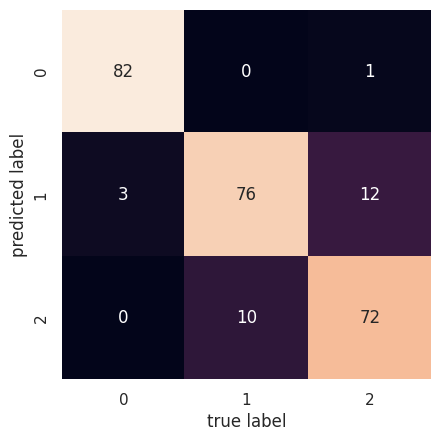

In [42]:
Suicide_test['prediction'] = Suicide_test['text'].map(safeguarding_prediction)

Suicide_test[['class', 'prob']]=pd.DataFrame(Suicide_test['prediction'].tolist(), index=Suicide_test.index)

Suicide_test['prediction'] = Suicide_test['class'].apply(lambda x: 2 if x == 'Strongly Concerning' else (1 if x == 'Possibly Concerning' else 0)) #

# We extract text and label values:
predicted = Suicide_test.prediction.values
labels = Suicide_test.label.values

cm2 = confusion_matrix(labels, predicted)

sns.heatmap(cm2.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [18]:
print(metrics.classification_report(predicted, labels)) 
class_report = metrics.classification_report(predicted, labels)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        81
           1       0.86      0.78      0.82        95
           2       0.80      0.85      0.82        80

    accuracy                           0.87       256
   macro avg       0.87      0.88      0.87       256
weighted avg       0.87      0.87      0.87       256



In [19]:
run.log('confusion_matrix_val', cm2)
run.log('classification_report_val', class_report )

# Deployment

# Set up Environment

## Serialise model 

In [18]:
#save model
model_file = short_hand_name+".pkl" 

In [19]:
#save model for later inference
torch.save(bert_model.state_dict(), model_file)

In [20]:
run.upload_file(name = 'outputs/' + model_file, path_or_stream = './' + model_file)

## Register Model 

In [21]:
# Register the model
run.register_model(model_path='outputs/'+model_file , model_name=name,
                   tags={'Training context':'Inline Training'} 
                   ,description="Safeguarding content detection model. Trained on balanced data, 3 categories, no safeguarding, safeguarding high risk, and low risk . "
                  )

print('Model trained and registered.')

Model trained and registered.


In [22]:

model = workspace.models[name]
print(model.name, 'version', model.version)

safeguarding_bert_bert3cat version 7


## Set Up local enivronment files

In [ ]:
import os
from IPython.core.magic import register_line_cell_magic

In [23]:
# Create a folder for the deployment files
deployment_folder = './'+name

# Set path for scoring script
script_file = 'score_'+short_hand_name +'.py'
script_path = os.path.join(deployment_folder,script_file)

In [ ]:
@register_line_cell_magic

def writetemplate(line, cell):
    """
    Writes formatted content to a file using a template provided in 'cell'.

    This function opens a file specified by the 'line' argument for writing. It then writes to this file
    using the string provided in 'cell', which is formatted using global variables available in the current
    scope.

    Args:
        line (str): The file path where the content will be written. If the file does not exist, it will be created.
                    If the file exists, its contents will be overwritten.
        cell (str): A string template containing placeholders that are filled using variables from the global scope.
                    Placeholders in the 'cell' string should be in the format {variable_name} where 'variable_name'
                    is a global variable.
    """
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))



In [25]:
%%writetemplate $script_path 
import json
import joblib
import numpy as np
import os
import pandas as pd
import pickle
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.nn.functional import F

 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Called when the service is loaded
def init():
    global model
    # Get the path to the deployed model file and load it    
    
    model  = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels = 3,
        output_attentions = False,
        output_hidden_states = False,
    )
    
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), '{model_file}')
    print(model_path)
    model.load_state_dict(torch.load( model_path, map_location=torch.device('cpu')))
    print(model)
    
    global tokenizer 
    tokenizer = BertTokenizer.from_pretrained(
        'bert-base-uncased',
        do_lower_case = True
    )

# Called when a request is received
def run(raw_data):
    # Get the input data as a numpy array    
    data = json.loads(raw_data)['data']


    def preprocessing(input_text, tokenizer):
        return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt' # Return pytorch tensors.
                   )


    def safeguarding_prediction(text_to_classify):
        # We need Token IDs and Attention Mask for inference on the new sentence
        test_ids = []
        test_attention_mask = []
        # Apply the tokenizer
        encoding = preprocessing(text_to_classify, tokenizer)

        # Extract IDs and Attention Mask
        test_ids.append(encoding['input_ids'])
        test_attention_mask.append(encoding['attention_mask'])
        test_ids = torch.cat(test_ids, dim = 0)
        test_attention_mask = torch.cat(test_attention_mask, dim = 0)

        # Forward pass, calculate logit predictions
        with torch.no_grad(): #not to construct the compute graph during this forward pass (since we won’t be running backprop here)
            output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

        prediction = 'Possibly Concerning' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else ('Strongly Concerning' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 2 else "No safeguarding")
        probs = F.softmax(output.logits.cpu(), dim=1).cpu().numpy() # Apply softmax to calculate probabilities
        probs_max = np.max(probs) # Apply softmax to calculate probabilities
        return prediction, str(probs_max)

    # Call prediction 
    predictions = safeguarding_prediction(data)
    
    # Return the predictions as JSON 
    return json.dumps(dict(enumerate(predictions))) 
